<h1 style="text-align: center;"> Capstone Project - The Battle of Neighborhoods </h1>

<h3>Introduction</h3>
This final project explores the best locations for Italian restaurants throughout Toronto. 

<h3>Data</h3>
In order to answer the above questions, data on Toronto neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

<h3> Methodology</h3>
• Data will be collected cleaned and processed into a dataframe.
• FourSquare be used to locate all venues and then filtered by Italian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.
• Data will be sorted based on rankings
• Finally, the data be will be visually assessed using graphing from various Python libraries.

<h3>Problem Statement</h3>
What is / are the best location(s) for Italian cuisine in Toronto?
In what Neighborhood and/or borough should I open an Italian restaurant to have the best chance of being successful?
Where would I go in Toronto to have the best Italian food?

In [5]:
import pandas as pd
import numpy as np
import requests
import os
from bs4 import BeautifulSoup

#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

In [37]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    CLIENT_ID = '5DLSLNR01F2AYWYVW3MPNFAM2O1Z30PSKEAFIX152RLY00SH'
    CLIENT_SECRET = 'LPAZIR3XAIVUXJO4DP4PROD21UGRXLMZFAY20UZLMPFKXMZZ'
    radius=400
    LIMIT=100
    VERSION='20210618'
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    CLIENT_ID = '5DLSLNR01F2AYWYVW3MPNFAM2O1Z30PSKEAFIX152RLY00SH'
    CLIENT_SECRET = 'LPAZIR3XAIVUXJO4DP4PROD21UGRXLMZFAY20UZLMPFKXMZZ'
    VERSION='20210618'
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

<h3> Part 1 - Web Scraping of Toronto Neighborhood Data from Wikipedia </h3>

In [6]:
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


<h3> Data Wrangling </h3>
<ol>
<li>Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.</li>
<li>More than one neighborhood can exist in one postal code area.  These two rows will be combined into one row with the neighborhoods separated with a comma.</li>
<li>If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.</li>
</ol>

In [7]:
# Droping the rows where Borough is 'Not assigned'
df1 = df[df.Borough != 'Not assigned']

# Combining the neighbourhoods with same Postalcode
df2 = df1.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])

df2.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [6]:
df2.shape

(103, 3)

 <h3> Adding Latitude and Longitude using the Geospatial DataSet </h3>

In [8]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
lat_lon.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df3 = pd.merge(df2,lat_lon,on='PostalCode')
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [13]:
# Get all rows from the dataframe that contains Borough as Toronto
df4 = df3.drop('PostalCode', axis=1)
df4

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...
98,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [14]:
df4.shape

(103, 4)

 <h3> Visualizing the above Data Set using Folium </h3>

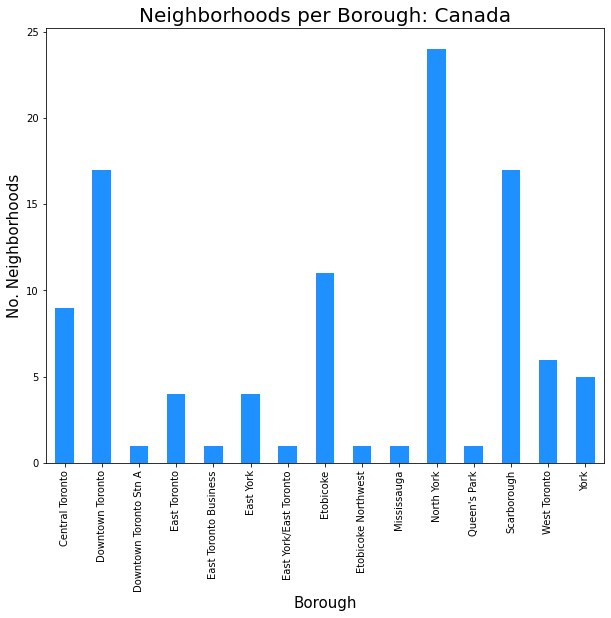

In [18]:
clr = "dodgerblue"
df4.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,8), color=clr)
plt.title('Neighborhoods per Borough: Canada', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

 <h3> Analyzing Italian Restaurants </h3>

In [25]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_canada=pd.DataFrame(columns=column_names)
count=1
for row in df4.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(df4),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_canada = italian_rest_canada.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Italian Resturants in Parkwoods, North York:0
['North York', 'Parkwoods', 43.7532586, -79.3296565]
( 2 / 103 ) Italian Resturants in Victoria Village, North York:0
['North York', 'Victoria Village', 43.7258823, -79.3155716]
( 3 / 103 ) Italian Resturants in Regent Park, Harbourfront, Downtown Toronto:0
['Downtown Toronto', 'Regent Park, Harbourfront', 43.6542599, -79.3606359]
( 4 / 103 ) Italian Resturants in Lawrence Manor, Lawrence Heights, North York:0
['North York', 'Lawrence Manor, Lawrence Heights', 43.718518, -79.4647633]
( 5 / 103 ) Italian Resturants in Ontario Provincial Government, Queen's Park:0
["Queen's Park", 'Ontario Provincial Government', 43.6623015, -79.3894938]
( 6 / 103 ) Italian Resturants in Islington Avenue, Etobicoke:0
['Etobicoke', 'Islington Avenue', 43.6678556, -79.5322424]
( 7 / 103 ) Italian Resturants in Malvern, Rouge, Scarborough:0
['Scarborough', 'Malvern, Rouge', 43.8066863, -79.1943534]
( 8 / 103 ) Italian Resturants in Don Mills North, N

( 58 / 103 ) Italian Resturants in Humberlea, Emery, North York:0
['North York', 'Humberlea, Emery', 43.7247659, -79.5322424]
( 59 / 103 ) Italian Resturants in Birch Cliff, Cliffside West, Scarborough:0
['Scarborough', 'Birch Cliff, Cliffside West', 43.692657, -79.2648481]
( 60 / 103 ) Italian Resturants in Willowdale South, North York:0
['North York', 'Willowdale South', 43.7701199, -79.4084928]
( 61 / 103 ) Italian Resturants in Downsview Northwest, North York:0
['North York', 'Downsview Northwest', 43.7616313, -79.5209994]
( 62 / 103 ) Italian Resturants in Lawrence Park, Central Toronto:0
['Central Toronto', 'Lawrence Park', 43.7280205, -79.3887901]
( 63 / 103 ) Italian Resturants in Roselawn, Central Toronto:0
['Central Toronto', 'Roselawn', 43.7116948, -79.4169356]
( 64 / 103 ) Italian Resturants in Runnymede, The Junction North, York:0
['York', 'Runnymede, The Junction North', 43.6731853, -79.4872619]
( 65 / 103 ) Italian Resturants in Weston, York:0
['York', 'Weston', 43.70687

In [26]:
italian_rest_canada.to_csv('italian_rest_canada_tocsv.csv') 
italian_rest_canada = pd.read_csv('italian_rest_canada_tocsv.csv')
italian_rest_canada.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
30,30,Downtown Toronto,"University of Toronto, Harbord",56eb72e3498eefb98d82274b,Piano Piano
31,31,Downtown Toronto Stn A,Enclave of M5E,4cb1169939458cfab0c908a0,Carisma
32,32,Downtown Toronto Stn A,Enclave of M5E,547bbfc8498e3bbc461bf215,Uncle Tony's Pizza and Pasta
33,33,Downtown Toronto,"St. James Town, Cabbagetown",4e4e7aa06365e1419d021044,F'Amelia
34,34,Downtown Toronto,"First Canadian Place, Underground city",4adc5c6af964a520da2b21e3,Mercatto


In [31]:
italian_rest_canada.shape

(35, 4)

 <h3>Further Analysing Restaurants and their Ratings </h3>

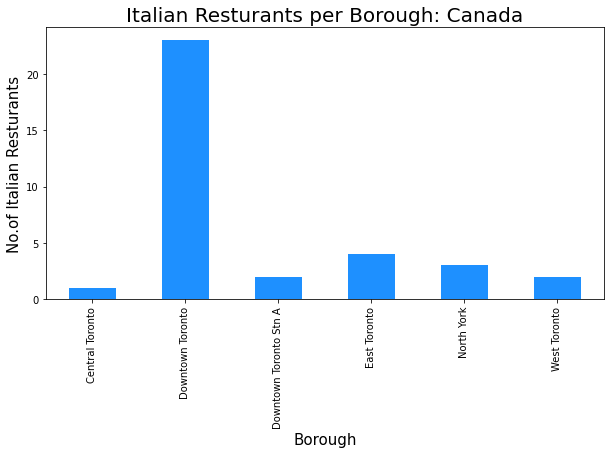

In [33]:
italian_rest_canada.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Resturants per Borough: Canada', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

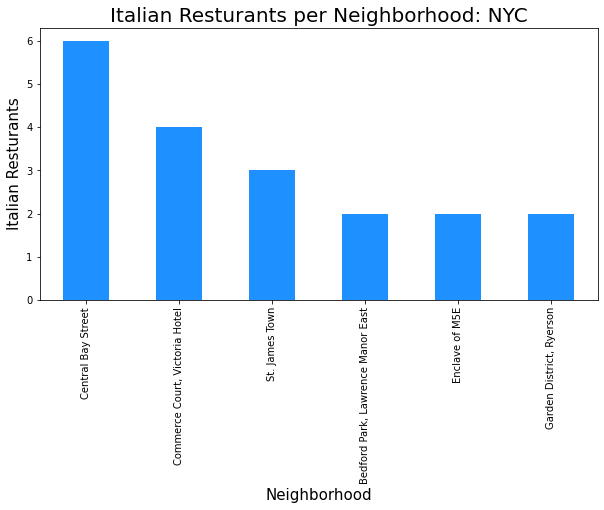

In [35]:
NOofNeigh = 6
italian_rest_canada.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

In [38]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_canada=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_canada.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_canada = italian_rest_stats_canada.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_canada.tail()

{'meta': {'code': 200, 'requestId': '60cc9c42b8196d792ac833bb'}, 'response': {'venue': {'id': '4afcc52df964a520b82522e3', 'name': 'Donatello Restaurant', 'contact': {'phone': '4165955001', 'formattedPhone': '(416) 595-5001'}, 'location': {'address': '37 Elm St.', 'crossStreet': 'at Bay St.', 'lat': 43.657489310288014, 'lng': -79.38360495100461, 'labeledLatLngs': [{'label': 'display', 'lat': 43.657489310288014, 'lng': -79.38360495100461}], 'postalCode': 'M5G 1H1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['37 Elm St. (at Bay St.)', 'Toronto ON M5G 1H1', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/donatello-restaurant/4afcc52df964a520b82522e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '60cc9c42ec945b4edfe18957'}, 'response': {'venue': {'id': '52f6816f11d24a43115dc834', 'name': 'Scaddabush Italian Kitchen & Bar', 'contact': {'phone': '4165978838', 'formattedPhone': '(416) 597-8838', 'twitter': 'scaddabush'}, 'location': {'address': '382 Yonge Street, Unit #7', 'crossStreet': 'Gerrard', 'lat': 43.658920292028725, 'lng': -79.38289105381784, 'labeledLatLngs': [{'label': 'display', 'lat': 43.658920292028725, 'lng': -79.38289105381784}], 'postalCode': 'M5B 1S8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['382 Yonge Street, Unit #7 (Gerrard)', 'Toronto ON M5B 1S8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/scaddabush-italian-kitchen--bar/52f6816f11d24a43115dc834', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suff

{'meta': {'code': 200, 'requestId': '60cc9c42bc58ac32f06306ac'}, 'response': {'venue': {'id': '4bdaff7463c5c9b67bcb2568', 'name': 'Sorento Restaurant', 'contact': {'phone': '4164473590', 'formattedPhone': '(416) 447-3590'}, 'location': {'address': '900 Don Mills Rd.', 'lat': 43.72657509457231, 'lng': -79.34198930569546, 'labeledLatLngs': [{'label': 'display', 'lat': 43.72657509457231, 'lng': -79.34198930569546}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['900 Don Mills Rd.', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/sorento-restaurant/4bdaff7463c5c9b67bcb2568', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c0941735', 'name': 'Mediterranean Restaurant', 'pluralName': 'Mediterranean Restaur

{'meta': {'code': 200, 'requestId': '60cc9c437348a6419a285dbc'}, 'response': {'venue': {'id': '4cb1169939458cfab0c908a0', 'name': 'Carisma', 'contact': {'phone': '4168647373', 'formattedPhone': '(416) 864-7373'}, 'location': {'address': '15 Toronto St', 'crossStreet': 'Toronto Street', 'lat': 43.64961671774303, 'lng': -79.3754337751762, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64961671774303, 'lng': -79.3754337751762}], 'postalCode': 'M5C 2E3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['15 Toronto St (Toronto Street)', 'Toronto ON M5C 2E3', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/carisma/4cb1169939458cfab0c908a0', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'ht

{'meta': {'code': 200, 'requestId': '60cc9c43a50fc23e5a7fd4bf'}, 'response': {'venue': {'id': '547bbfc8498e3bbc461bf215', 'name': "Uncle Tony's Pizza and Pasta", 'contact': {}, 'location': {'address': '38 Wellington Street East', 'crossStreet': 'Wellington and Scott', 'lat': 43.64828690534951, 'lng': -79.37500477402445, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64828690534951, 'lng': -79.37500477402445}], 'postalCode': 'M5V 1C7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['38 Wellington Street East (Wellington and Scott)', 'Toronto ON M5V 1C7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/uncle-tonys-pizza-and-pasta/547bbfc8498e3bbc461bf215', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735',

{'meta': {'code': 200, 'requestId': '60cc9c445fe4ab50fed8bf5b'}, 'response': {'venue': {'id': '4afcc52df964a520b82522e3', 'name': 'Donatello Restaurant', 'contact': {'phone': '4165955001', 'formattedPhone': '(416) 595-5001'}, 'location': {'address': '37 Elm St.', 'crossStreet': 'at Bay St.', 'lat': 43.657489310288014, 'lng': -79.38360495100461, 'labeledLatLngs': [{'label': 'display', 'lat': 43.657489310288014, 'lng': -79.38360495100461}], 'postalCode': 'M5G 1H1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['37 Elm St. (at Bay St.)', 'Toronto ON M5G 1H1', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/donatello-restaurant/4afcc52df964a520b82522e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '60cc9c44bc58ac32f0630b2f'}, 'response': {'venue': {'id': '52f6816f11d24a43115dc834', 'name': 'Scaddabush Italian Kitchen & Bar', 'contact': {'phone': '4165978838', 'formattedPhone': '(416) 597-8838', 'twitter': 'scaddabush'}, 'location': {'address': '382 Yonge Street, Unit #7', 'crossStreet': 'Gerrard', 'lat': 43.658920292028725, 'lng': -79.38289105381784, 'labeledLatLngs': [{'label': 'display', 'lat': 43.658920292028725, 'lng': -79.38289105381784}], 'postalCode': 'M5B 1S8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['382 Yonge Street, Unit #7 (Gerrard)', 'Toronto ON M5B 1S8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/scaddabush-italian-kitchen--bar/52f6816f11d24a43115dc834', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suff

{'meta': {'code': 200, 'requestId': '60cc9c44c4c79f6081f845ef'}, 'response': {'venue': {'id': '54fb2f8d498e724a96c14f91', 'name': 'Tosto', 'contact': {'phone': '6473448866', 'formattedPhone': '(647) 344-8866', 'twitter': 'tostoquickfire', 'facebook': '1470894756516126', 'facebookUsername': 'tostoquickfire', 'facebookName': 'TOSTO QUICKFIRE PIZZA PASTA'}, 'location': {'address': '800 Bay St', 'lat': 43.661198, 'lng': -79.386414, 'labeledLatLngs': [{'label': 'display', 'lat': 43.661198, 'lng': -79.386414}], 'postalCode': 'M5S 3A9', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['800 Bay St', 'Toronto ON M5S 3A9', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/tosto/54fb2f8d498e724a96c14f91', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, 

{'meta': {'code': 200, 'requestId': '60cc9c4448e3a9610f32ac71'}, 'response': {'venue': {'id': '529d18c911d255c5406ddd88', 'name': 'Pizzeria Via Mercanti', 'contact': {'phone': '4169011899', 'formattedPhone': '(416) 901-1899', 'twitter': 'via_mercanti'}, 'location': {'address': '87 Elm St', 'crossStreet': 'Btwn University Ave & Elizabeth St', 'lat': 43.65679034740686, 'lng': -79.38631071713952, 'labeledLatLngs': [{'label': 'display', 'lat': 43.65679034740686, 'lng': -79.38631071713952}], 'postalCode': 'M5G 0A8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['87 Elm St (Btwn University Ave & Elizabeth St)', 'Toronto ON M5G 0A8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pizzeria-via-mercanti/529d18c911d255c5406ddd88', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suf

{'meta': {'code': 200, 'requestId': '60cc9c45f9ca5e4bfbcd581e'}, 'response': {'venue': {'id': '4be9a4376295c9b65e788508', 'name': 'Pastacceria', 'contact': {}, 'location': {'address': 'Mars', 'lat': 43.66002046385312, 'lng': -79.38818802617249, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66002046385312, 'lng': -79.38818802617249}], 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['Mars', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pastacceria/4be9a4376295c9b65e788508', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere': {'count': 0, 'unconfirmedCount': 0, 'm

{'meta': {'code': 200, 'requestId': '60cc9c452f362615cbc11fff'}, 'response': {'venue': {'id': '54b9b9aa498e6f9349fd2125', 'name': 'Taverna Mercatto', 'contact': {}, 'location': {'address': '130 Bremner', 'lat': 43.64262514139939, 'lng': -79.38325673989138, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64262514139939, 'lng': -79.38325673989138}], 'cc': 'CA', 'country': 'Canada', 'formattedAddress': ['130 Bremner', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/taverna-mercatto/54b9b9aa498e6f9349fd2125', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 73, 'groups': [{'type': 'others', 'count': 73, 'items': []}], 'summary': '73 Likes'}, 'dislike': Fal

{'meta': {'code': 200, 'requestId': '60cc9c462d36c519ad1ee2f0'}, 'response': {'venue': {'id': '4d75709afc766a31c3378e1a', 'name': 'Aria Ristorante', 'contact': {'phone': '4163632742', 'formattedPhone': '(416) 363-2742', 'facebook': '132134163526558', 'facebookName': 'Aria Ristorante'}, 'location': {'address': '25 York St.', 'crossStreet': 'at Bremner Blvd.', 'lat': 43.64329880302282, 'lng': -79.38103414760897, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64329880302282, 'lng': -79.38103414760897}], 'postalCode': 'M5J 2V5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['25 York St. (at Bremner Blvd.)', 'Toronto ON M5J 2V5', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/aria-ristorante/4d75709afc766a31c3378e1a', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix':

{'meta': {'code': 200, 'requestId': '60cc9c46e532cf216e922e26'}, 'response': {'venue': {'id': '56aabee1498ebfd21c627b88', 'name': 'Ufficio', 'contact': {'phone': '4165358888', 'formattedPhone': '(416) 535-8888', 'twitter': 'ufficiotoronto'}, 'location': {'address': '1214 Dundas St W', 'lat': 43.649439390888254, 'lng': -79.42301401069709, 'labeledLatLngs': [{'label': 'display', 'lat': 43.649439390888254, 'lng': -79.42301401069709}], 'postalCode': 'M6J 1X5', 'cc': 'CA', 'neighborhood': 'Dufferin Grove, Toronto, ON', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1214 Dundas St W', 'Toronto ON M6J 1X5', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/ufficio/56aabee1498ebfd21c627b88', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '60cc9c46fbf23637954b6067'}, 'response': {'venue': {'id': '4af4e0d0f964a5202ff721e3', 'name': '7 Numbers', 'contact': {'phone': '4164695183', 'formattedPhone': '(416) 469-5183', 'twitter': '7_numbers'}, 'location': {'address': '307 Danforth Ave.', 'crossStreet': 'at Bowden St', 'lat': 43.677061774959824, 'lng': -79.35393428891682, 'labeledLatLngs': [{'label': 'display', 'lat': 43.677061774959824, 'lng': -79.35393428891682}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['307 Danforth Ave. (at Bowden St)', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/7-numbers/4af4e0d0f964a5202ff721e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}, 'url':

{'meta': {'code': 200, 'requestId': '60cc9c47f9ca5e4bfbcd5d6f'}, 'response': {'venue': {'id': '4adc5c6af964a520da2b21e3', 'name': 'Mercatto', 'contact': {'phone': '4163060467', 'formattedPhone': '(416) 306-0467'}, 'location': {'address': '330 Bay St.', 'crossStreet': 'btwn Temperance & Adelaide', 'lat': 43.6502431921682, 'lng': -79.38081989149896, 'labeledLatLngs': [{'label': 'display', 'lat': 43.6502431921682, 'lng': -79.38081989149896}], 'postalCode': 'M5H 2S8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['330 Bay St. (btwn Temperance & Adelaide)', 'Toronto ON M5H 2S8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/mercatto/4adc5c6af964a520da2b21e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '60cc9c47e532cf216e923165'}, 'response': {'venue': {'id': '4b632632f964a52085662ae3', 'name': 'Caffino', 'contact': {'phone': '4165887695', 'formattedPhone': '(416) 588-7695'}, 'location': {'address': '1185 King St W', 'crossStreet': 'at Fraser Ave', 'lat': 43.63902121044261, 'lng': -79.42528923382933, 'labeledLatLngs': [{'label': 'display', 'lat': 43.63902121044261, 'lng': -79.42528923382933}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1185 King St W (at Fraser Ave)', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/caffino/4b632632f964a52085662ae3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'price': {'tier': 3, 'message': 'Expensi

{'meta': {'code': 200, 'requestId': '60cc9c4839d25c500a2d1c7a'}, 'response': {'venue': {'id': '4b2d7d0ff964a520b5d724e3', 'name': 'Mirto', 'contact': {'phone': '4166011780', 'formattedPhone': '(416) 601-1780'}, 'location': {'address': '25 Toronto Street', 'crossStreet': 'Adelaide Street', 'lat': 43.650702, 'lng': -79.376307, 'labeledLatLngs': [{'label': 'display', 'lat': 43.650702, 'lng': -79.376307}], 'postalCode': 'M5C 2R1', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['25 Toronto Street (Adelaide Street)', 'Toronto ON M5C 2R1', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/mirto/4b2d7d0ff964a520b5d724e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'M

{'meta': {'code': 200, 'requestId': '60cc9c48b8196d792ac84534'}, 'response': {'venue': {'id': '4adc5c6af964a520da2b21e3', 'name': 'Mercatto', 'contact': {'phone': '4163060467', 'formattedPhone': '(416) 306-0467'}, 'location': {'address': '330 Bay St.', 'crossStreet': 'btwn Temperance & Adelaide', 'lat': 43.6502431921682, 'lng': -79.38081989149896, 'labeledLatLngs': [{'label': 'display', 'lat': 43.6502431921682, 'lng': -79.38081989149896}], 'postalCode': 'M5H 2S8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['330 Bay St. (btwn Temperance & Adelaide)', 'Toronto ON M5H 2S8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/mercatto/4adc5c6af964a520da2b21e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '60cc9c49b31a576a9737ee16'}, 'response': {'venue': {'id': '547bbfc8498e3bbc461bf215', 'name': "Uncle Tony's Pizza and Pasta", 'contact': {}, 'location': {'address': '38 Wellington Street East', 'crossStreet': 'Wellington and Scott', 'lat': 43.64828690534951, 'lng': -79.37500477402445, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64828690534951, 'lng': -79.37500477402445}], 'postalCode': 'M5V 1C7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['38 Wellington Street East (Wellington and Scott)', 'Toronto ON M5V 1C7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/uncle-tonys-pizza-and-pasta/547bbfc8498e3bbc461bf215', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735',

{'meta': {'code': 200, 'requestId': '60cc9c49e534a14c61c5f250'}, 'response': {'venue': {'id': '54bd9fa8498e72620bb03b45', 'name': 'Francobollo', 'contact': {'phone': '4164813888', 'formattedPhone': '(416) 481-3888'}, 'location': {'address': '1959 avenue rd', 'lat': 43.734556923055784, 'lng': -79.41954908679143, 'labeledLatLngs': [{'label': 'display', 'lat': 43.734556923055784, 'lng': -79.41954908679143}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1959 avenue rd', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/francobollo/54bd9fa8498e72620bb03b45', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://francobollo.ca', 'price': {'tier': 4, 'message': 'Very Expensive

{'meta': {'code': 200, 'requestId': '60cc9c49f9ca5e4bfbcd6411'}, 'response': {'venue': {'id': '4b71edddf964a520cb642de3', 'name': 'Positano', 'contact': {'phone': '4169323982', 'formattedPhone': '(416) 932-3982'}, 'location': {'address': '633 Mt. Pleasant Rd.', 'crossStreet': 'btwn. Hillsdale Ave. E and Manor Rd. E', 'lat': 43.704558, 'lng': -79.38863854, 'labeledLatLngs': [{'label': 'display', 'lat': 43.704558, 'lng': -79.38863854}], 'postalCode': 'M4S 2M9', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['633 Mt. Pleasant Rd. (btwn. Hillsdale Ave. E and Manor Rd. E)', 'Toronto ON M4S 2M9', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/positano/4b71edddf964a520cb642de3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False

{'meta': {'code': 200, 'requestId': '60cc9c4a5566da5ba0afcf0b'}, 'response': {'venue': {'id': '4cb1169939458cfab0c908a0', 'name': 'Carisma', 'contact': {'phone': '4168647373', 'formattedPhone': '(416) 864-7373'}, 'location': {'address': '15 Toronto St', 'crossStreet': 'Toronto Street', 'lat': 43.64961671774303, 'lng': -79.3754337751762, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64961671774303, 'lng': -79.3754337751762}], 'postalCode': 'M5C 2E3', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['15 Toronto St (Toronto Street)', 'Toronto ON M5C 2E3', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/carisma/4cb1169939458cfab0c908a0', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'ht

{'meta': {'code': 200, 'requestId': '60cc9c4ae98ecd4ea8d86c0d'}, 'response': {'venue': {'id': '547bbfc8498e3bbc461bf215', 'name': "Uncle Tony's Pizza and Pasta", 'contact': {}, 'location': {'address': '38 Wellington Street East', 'crossStreet': 'Wellington and Scott', 'lat': 43.64828690534951, 'lng': -79.37500477402445, 'labeledLatLngs': [{'label': 'display', 'lat': 43.64828690534951, 'lng': -79.37500477402445}], 'postalCode': 'M5V 1C7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['38 Wellington Street East (Wellington and Scott)', 'Toronto ON M5V 1C7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/uncle-tonys-pizza-and-pasta/547bbfc8498e3bbc461bf215', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca941735',

{'meta': {'code': 200, 'requestId': '60cc9c4b39d25c500a2d246b'}, 'response': {'venue': {'id': '4adc5c6af964a520da2b21e3', 'name': 'Mercatto', 'contact': {'phone': '4163060467', 'formattedPhone': '(416) 306-0467'}, 'location': {'address': '330 Bay St.', 'crossStreet': 'btwn Temperance & Adelaide', 'lat': 43.6502431921682, 'lng': -79.38081989149896, 'labeledLatLngs': [{'label': 'display', 'lat': 43.6502431921682, 'lng': -79.38081989149896}], 'postalCode': 'M5H 2S8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['330 Bay St. (btwn Temperance & Adelaide)', 'Toronto ON M5H 2S8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/mercatto/4adc5c6af964a520da2b21e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
30,Downtown Toronto,"University of Toronto, Harbord",56eb72e3498eefb98d82274b,Piano Piano,59,7.2,13
31,Downtown Toronto Stn A,Enclave of M5E,4cb1169939458cfab0c908a0,Carisma,22,7.9,8
32,Downtown Toronto Stn A,Enclave of M5E,547bbfc8498e3bbc461bf215,Uncle Tony's Pizza and Pasta,5,7.1,2
33,Downtown Toronto,"St. James Town, Cabbagetown",4e4e7aa06365e1419d021044,F'Amelia,30,8.4,17
34,Downtown Toronto,"First Canadian Place, Underground city",4adc5c6af964a520da2b21e3,Mercatto,46,6.8,26


In [40]:
italian_rest_stats_canada.to_csv('italian_rest_stats_canada_csv.csv')
italian_rest_stats_canada.tail
italian_rest_stats_canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       35 non-null     object 
 1   Neighborhood  35 non-null     object 
 2   ID            35 non-null     object 
 3   Name          35 non-null     object 
 4   Likes         35 non-null     object 
 5   Rating        35 non-null     float64
 6   Tips          35 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.0+ KB


In [41]:
italian_rest_stats_canada['Likes']=italian_rest_stats_canada['Likes'].astype('float64')
italian_rest_stats_canada['Tips']=italian_rest_stats_canada['Tips'].astype('float64')
italian_rest_stats_canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       35 non-null     object 
 1   Neighborhood  35 non-null     object 
 2   ID            35 non-null     object 
 3   Name          35 non-null     object 
 4   Likes         35 non-null     float64
 5   Rating        35 non-null     float64
 6   Tips          35 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.0+ KB


In [42]:
cn_neighborhood_stats=italian_rest_stats_canada.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
cn_neighborhood_stats.columns=['Neighborhood','Average Rating']
cn_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)
cn_borough_stats=italian_rest_stats_canada.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
cn_borough_stats.columns=['Borough','Average Rating']
cn_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
5,West Toronto,8.450000
3,East Toronto,8.225000
2,Downtown Toronto Stn A,7.500000
0,Central Toronto,7.000000
1,Downtown Toronto,6.791304


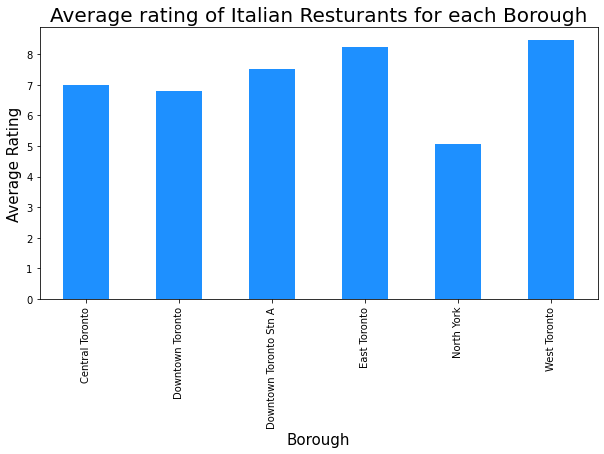

In [44]:
italian_rest_stats_canada.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

In [45]:
cn_neighborhood_stats=cn_neighborhood_stats[cn_neighborhood_stats['Average Rating']>=8.0]
cn_neighborhood_stats

,Neighborhood,Average Rating
1,"Brockton, Parkdale Village, Exhibition Place",8.50
3,Christie,8.10
6,Don Mills South,8.20
12,"Little Portugal, Trinity",8.40
15,"St. James Town, Cabbagetown",8.40
16,Studio District,8.30
17,"The Danforth West, Riverdale",8.55


In [46]:
cn_neighborhood_stats=pd.merge(cn_neighborhood_stats,df4, on='Neighborhood')
cn_neighborhood_stats=cn_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
cn_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,8.50
1,Downtown Toronto,Christie,43.669542,-79.422564,8.10
2,North York,Don Mills South,43.725900,-79.340923,8.20
3,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,8.40
4,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,8.40
5,East Toronto,Studio District,43.659526,-79.340923,8.30
6,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,8.55


In [55]:
# create map and display it
cn_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in cn_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [56]:
cn_neighborhood_stats['Label']=cn_neighborhood_stats['Neighborhood']+', '+cn_neighborhood_stats['Borough']+'('+cn_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in cn_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(cn_map)        
# add incidents to map
cn_map.add_child(incidents)